# Simulated/"hybrid" Motion

In [1]:
from typing import List
from matplotlib import pyplot as plt
import numpy as np

In [2]:
WASA_THRESHOLD = 0.93
BALANCE_WEIGHTS = True

### Comparison: WASA93, ROC AUC, Cohen's Kappa

* WASA93: <u>W</u>ake <u>A</u>ccuracy when <u>S</u>leep <u>A</u>ccuracy is fixed at <u>93%</u>

In [3]:
from pisces.utils import pad_to_hat, plot_scores_CDF, plot_scores_PDF, add_rocs

In [4]:
import matplotlib.pyplot as plt

from pisces.data_sets import DataSetObject


sets = DataSetObject.find_data_sets("../data_sets")
walch = sets['walch_et_al']
hybrid = sets['hybrid_motion']

# Walch et al. data set

## (MO) Pretrained UNet evaluation
We have the trained weights from Mads Olsen et al.'s _ResUNet_ model, saved as a tensorflow lite model with a wrapper for our system. This section calls that on accelerometer recordings in the `'walch_et_al'` data set.

In [5]:
from pisces.models import MOResUNetPretrained
from pisces.utils import split_analysis


mo = MOResUNetPretrained(sampling_hz=32)


In [6]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)
evaluations_walch, mo_preprocessed_data_walch = mo.evaluate_data_set(walch)
mo_aucs_walch = [e["auc"] for e in evaluations_walch.values()]
mo_fprs_walch = [e["roc_curve"]["fprs"] for e in evaluations_walch.values()]
mo_tprs_walch = [e["roc_curve"]["tprs"] for e in evaluations_walch.values()]


Using 16 of 16 cores (100%) for parallel preprocessing.
This can cause memory or heat issues if  is too high; if you run into problems, call prepare_set_for_training() again with max_workers = -1, going more negative if needed. (See the docstring for more info.)
getting needed X, y for 3509524
sampling hz: 32
masking
Masked 1 PSG epochs
resampling to 32Hz (0.03125s) from 66 Hz (0.01501s)
getting needed X, y for 1449548
getting needed X, y for 4018081
getting needed X, y for 4314139
sampling hz: 32
masking
sampling hz: 32
masking
Masked 1 PSG epochs
resampling to 32Hz (0.03125s) from 66 Hz (0.01502s)
sampling hz: 32
masking
Masked 1 PSG epochs
Masked 1 PSG epochs
resampling to 32Hz (0.03125s) from 50 Hz (0.01986s)
getting needed X, y for 5383425
getting needed X, y for 46343
resampling to 32Hz (0.03125s) from 50 Hz (0.01998s)
sampling hz: 32
masking
Masked 1 PSG epochs
resampling to 32Hz (0.03125s) from 10 Hz (0.09990s)
getting needed X, y for 5132496
getting needed X, y for 2638030
get

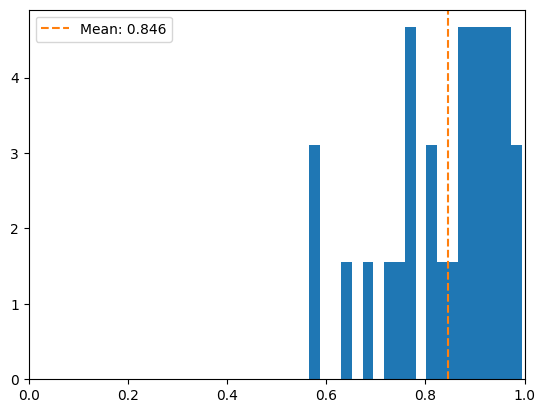

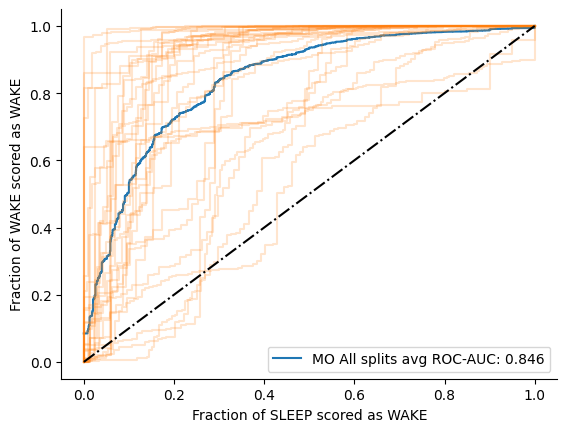

In [7]:
plot_scores_PDF(mo_aucs_walch)

add_rocs(mo_fprs_walch, mo_tprs_walch, roc_group_name="MO")

### debugging

In [8]:
import random


w = sets['walch_et_al']
(X, y), id  = mo_preprocessed_data_walch[1]
print("X.shape =", X.shape)
spec = X[0, 1:, :, 0].T

print("spec.shape =", spec.shape)


X.shape = (1, 15360, 32, 2)
spec.shape = (32, 15359)


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_spectrogram(preprocessed_data, idx):
    (X, y), id = preprocessed_data[idx]
    spec = X[0, 1:, :, 0].T

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

    img = ax1.imshow(spec, origin="lower", aspect="auto")#, vmin=vmin, vmax=vmax)
    ax1.set_title('Spectrogram, Time : Freq')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Freq')

    axins = inset_axes(ax1,
                    width="5%",  # width = 5% of parent_bbox width
                    height="75%",  # height : 50%
                    loc='center right')

    plt.colorbar(img, cax=axins, orientation="vertical")

    ax3.plot(spec)
    ax3.set_title('Spectrogram, Frequency : Power ')
    ax3.set_xlabel('Freq')
    ax3.set_ylabel('Power')
    ax3.set_xlim(0, 31)#spec.shape[0])


    ax2.plot(spec.T)
    ax2.set_title('Spectrogram, Time : Power')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Power')
    ax2.set_xlim(0, spec.shape[1])

    plt.tight_layout(pad=0.3)
    fig.suptitle(f"Subject {id}")
    plt.show()


In [10]:

def plot_predictions(evaluations, y_time, idx):
    time_len = len(y_time)
    y_pad = evaluations[idx]["y_padded"][:time_len]
    y_pred = evaluations[idx]["y_hat"][:time_len]
    y_mask = evaluations[idx]["mask"][:time_len]

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(y_time, y_pad, label="True")
    ax.plot(y_time, y_pred, label="Predicted")
    ax.plot(y_time, y_mask, label="Mask")
    ax.legend(loc='upper right')

/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_88909/4131756062.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


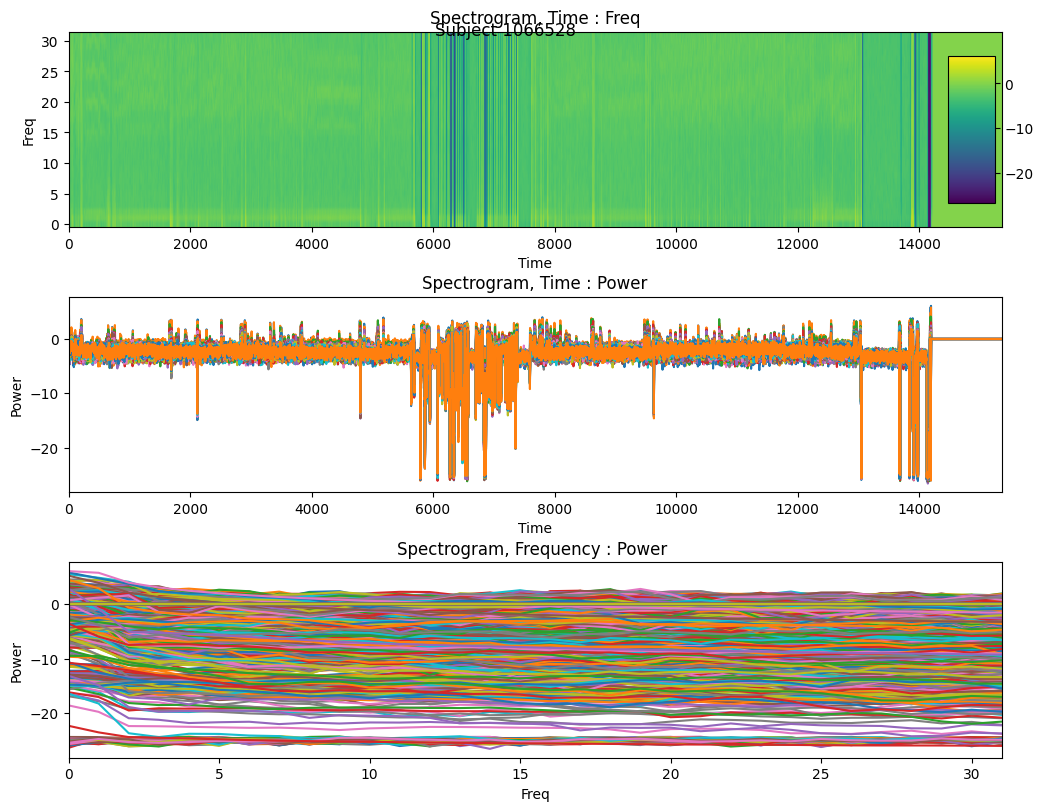

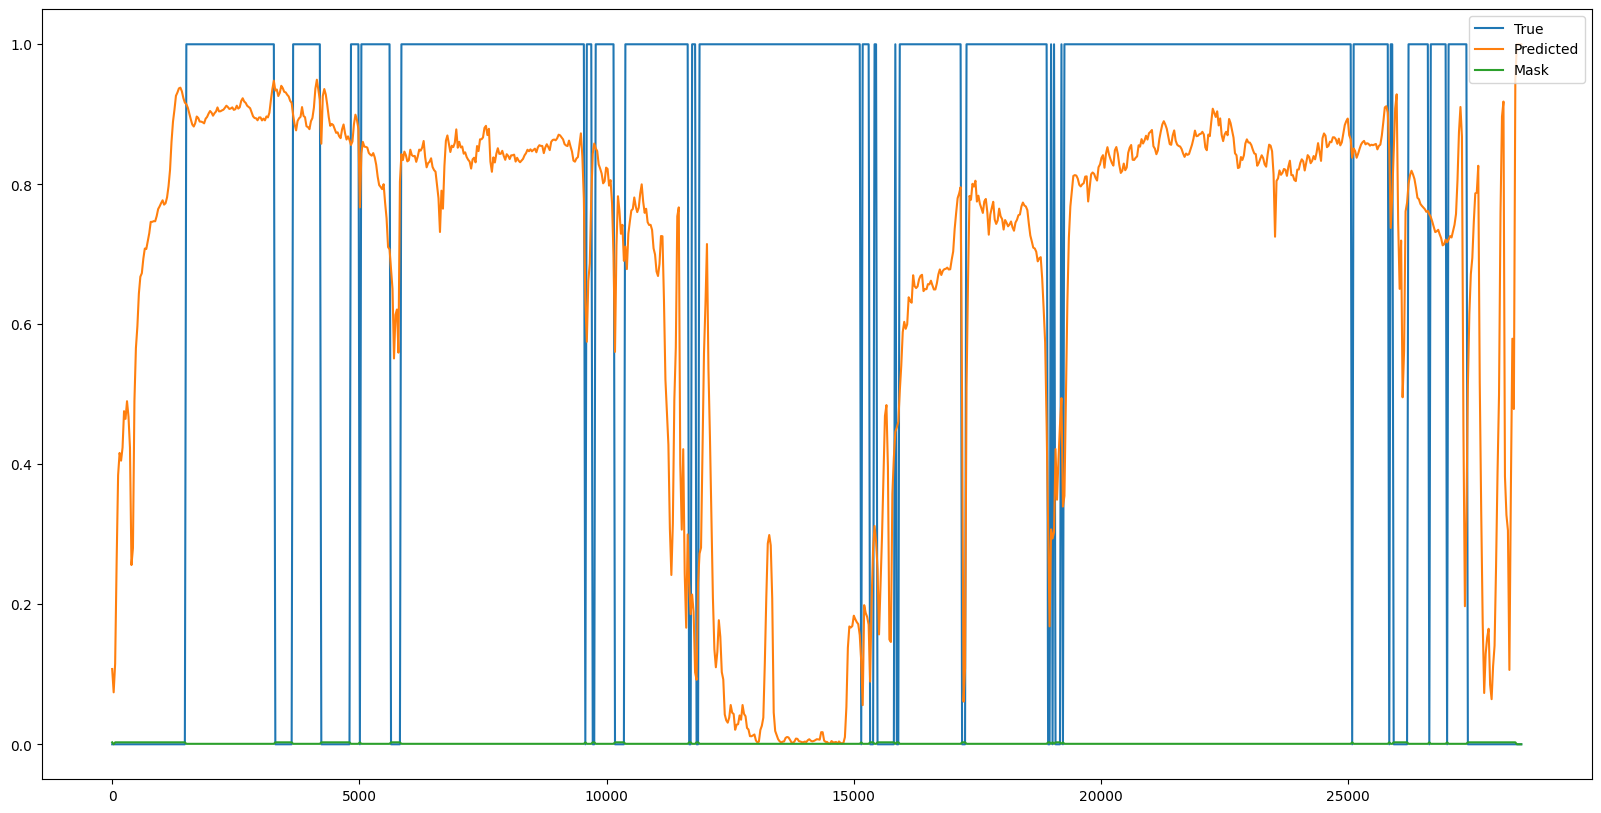

In [11]:
index = 0
_, id = mo_preprocessed_data_walch[index]
psg = w.get_feature_data("psg", id)
psg_time = psg[:, 0].to_numpy()

plot_spectrogram(mo_preprocessed_data_walch, index)
# broken now that evaluations_walch is a dict
# think we want to just use 
plot_predictions(evaluations=evaluations_walch, y_time=psg_time, idx=id)

## LOO + SGD Log Reg classifier
Adding LOOX can be achieved by training on 'walch_et_al' and testing on 'hybrid_data'.

In [12]:

from pisces.models import LeaveOneOutSplitter, SGDLogisticRegression, run_splits

DATA_SET = walch
loo = LeaveOneOutSplitter()

split_models, log_reg_preprocessed_data_walch, splits = run_splits(loo, DATA_SET, SGDLogisticRegression)

masking
Masked 1 PSG epochs
masking
Masked 2 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
ID 7749105 not found in walch_et_al
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs


31it [00:03, 10.10it/s]


In [13]:

from typing import Dict


log_reg_preprocessed_data_walch = [l for l in log_reg_preprocessed_data_walch if l[0] is not None]
log_reg_evaluations_walch: Dict[str, dict] = {}
for i, ((X, y), id) in enumerate(log_reg_preprocessed_data_walch):
    y_hat_proba = split_models[i].predict_probabilities(X)
    y_hat_sleep_proba = y_hat_proba[:, 1].reshape(-1,)
    y_prepped, _ = SGDLogisticRegression()._prepare_labels(y)
    try:
        analysis = split_analysis(y_prepped, y_hat_sleep_proba, balancing=False)
    except ValueError as e:
        print(f"Error processing {id}: {e}")
        continue
    log_reg_evaluations_walch[id] = analysis
    print(f"Processing {i+1} of {len(log_reg_preprocessed_data_walch)} ({id})... AUROC: {analysis['auc']}")
log_reg_aucs_walch = [e["auc"] for e in log_reg_evaluations_walch.values()]
log_reg_fprs_walch = [e["roc_curve"]["fprs"] for e in log_reg_evaluations_walch.values()]
log_reg_tprs_walch = [e["roc_curve"]["tprs"] for e in log_reg_evaluations_walch.values()]


/Users/eric/Engineering/Work/pisces/pisces/utils.py:424: UserWarning: y_hat is shorter than y by -42 elements, returning y unchanged
  warnings.warn(f"y_hat is shorter than y by {pad} elements, returning y unchanged")


Processing 1 of 30 (1066528)... AUROC: 0.7313786905101711
Error processing 1360686: Found input variables with inconsistent numbers of samples: [956, 914, 956]
Processing 3 of 30 (1449548)... AUROC: 0.7650381850853548
Processing 4 of 30 (1455390)... AUROC: 0.8265432163934071
Processing 5 of 30 (1818471)... AUROC: 0.8901823387582883
Processing 6 of 30 (2598705)... AUROC: 0.9057435090479936
Processing 7 of 30 (2638030)... AUROC: 0.891845730027549
Processing 8 of 30 (3509524)... AUROC: 0.9224439775910367
Processing 9 of 30 (3997827)... AUROC: 0.9735263280521894
Processing 10 of 30 (4018081)... AUROC: 0.8926360208917026
Processing 11 of 30 (4314139)... AUROC: 0.8819795048349646
Processing 12 of 30 (4426783)... AUROC: 0.964477383082035
Processing 13 of 30 (46343)... AUROC: 0.8684980413546886
Processing 14 of 30 (5132496)... AUROC: 0.6914285714285711
Processing 15 of 30 (5383425)... AUROC: 0.9765222703866406
Processing 16 of 30 (5498603)... AUROC: 0.8522514725998713
Processing 17 of 30 (5797

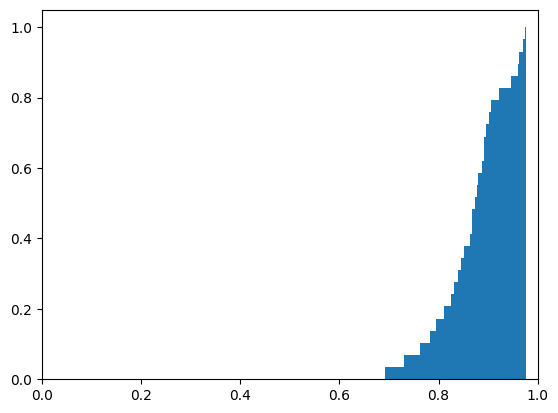

In [14]:
plot_scores_CDF(log_reg_aucs_walch)

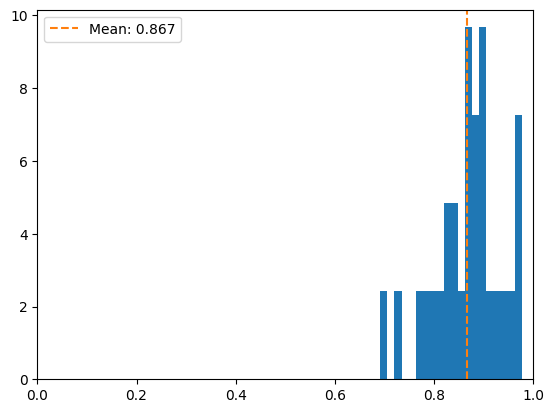

In [15]:
plot_scores_PDF(log_reg_aucs_walch)

### Comparision: ROC

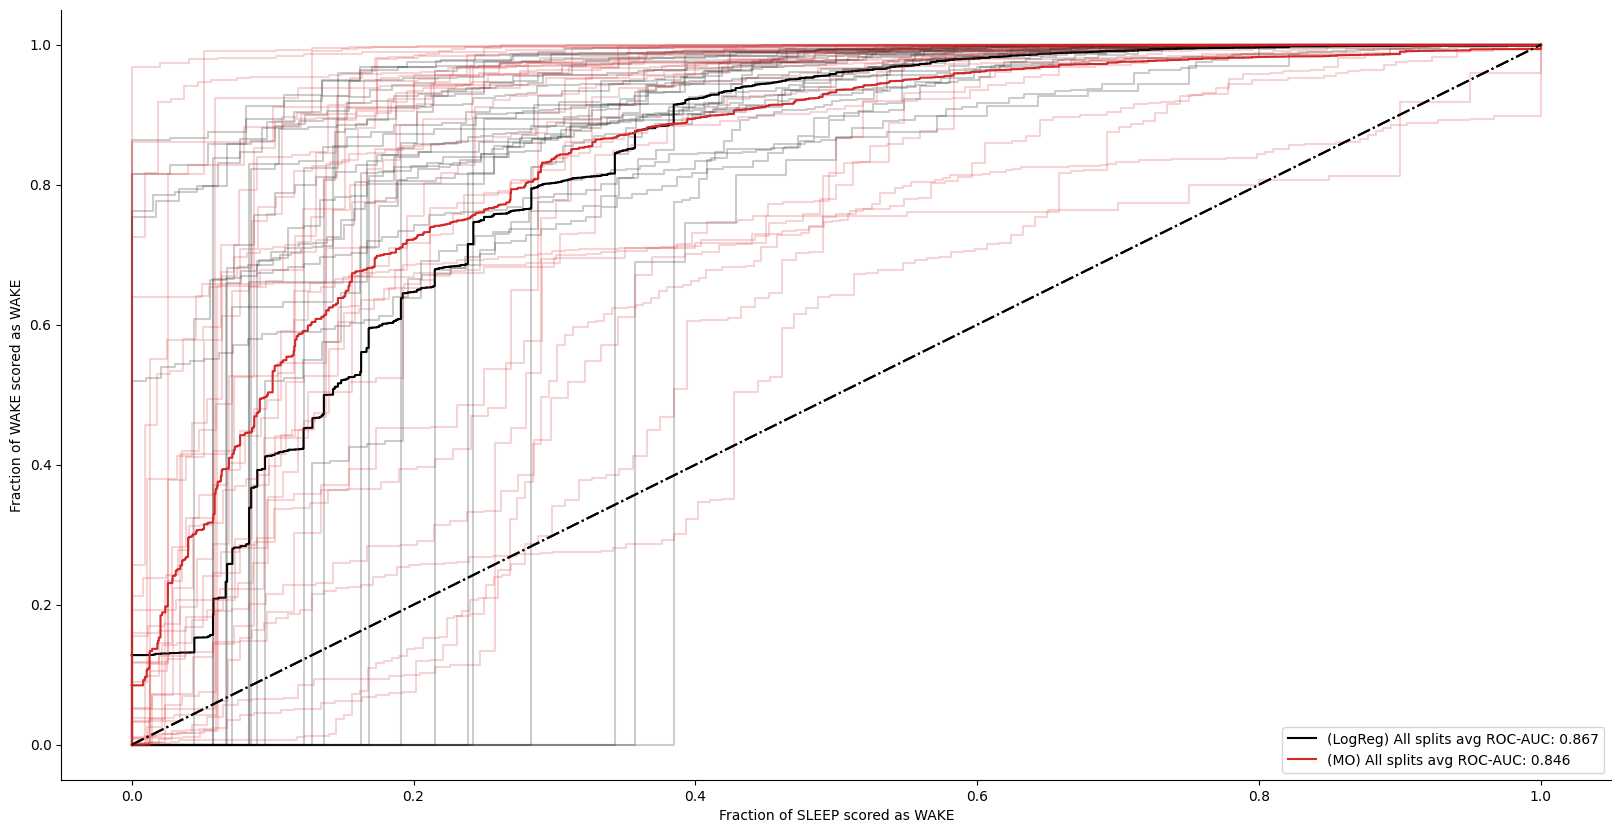

In [16]:


fig, ax = plt.subplots(figsize=(20, 10))
lr_color = "black"
mo_color = "tab:red"

add_rocs(
    fprs=log_reg_fprs_walch, 
    tprs=log_reg_tprs_walch,
    avg_curve_color=lr_color,
    specific_curve_color=lr_color,
    roc_group_name="(LogReg)",
    ax=ax,
    min_auc=0.5,
)

add_rocs(
    fprs=mo_fprs_walch,
    tprs=mo_tprs_walch,
    avg_curve_color=mo_color,
    specific_curve_color=mo_color,
    roc_group_name="(MO)",
    ax=ax,
    min_auc=0.5,
)
ax.legend(loc='lower right')

# Hybrid data set

In [17]:
# uses all processors on your CPU to preprocess the accelerometer into spectrograms
# takes ~ 50 sec on M1 Pro (10core)

evaluations_hybrid, mo_preprocessed_data_hybrid = mo.evaluate_data_set(hybrid)
mo_aucs_hybrid = [e["auc"] for e in evaluations_hybrid.values()]
mo_fprs_hybrid = [e["roc_curve"]["fprs"] for e in evaluations_hybrid.values()]
mo_tprs_hybrid = [e["roc_curve"]["tprs"] for e in evaluations_hybrid.values()]


Using 16 of 16 cores (100%) for parallel preprocessing.
This can cause memory or heat issues if  is too high; if you run into problems, call prepare_set_for_training() again with max_workers = -1, going more negative if needed. (See the docstring for more info.)
getting needed X, y for 1360686
sampling hz: 32
masking
Masked 2 PSG epochs
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
getting needed X, y for 1455390
getting needed X, y for 2598705
getting needed X, y for 1066528
sampling hz: 32
masking
Masked 1 PSG epochs
sampling hz: 32
masking
resampling to 32Hz (0.03125s) from 50 Hz (0.01999s)
getting needed X, y for 1818471
Masked 2 PSG epochs
sampling hz: 32
masking
resampling to 32Hz (0.03125s) from 50 Hz (0.01977s)
getting needed X, y for 1449548
getting needed X, y for 2638030
Masked 1 PSG epochs
getting needed X, y for 4018081
resampling to 32Hz (0.03125s) from 49 Hz (0.02001s)
getting needed X, y for 46343
sampling hz: 32
masking
sampling hz: 32
masking
getting needed X, y

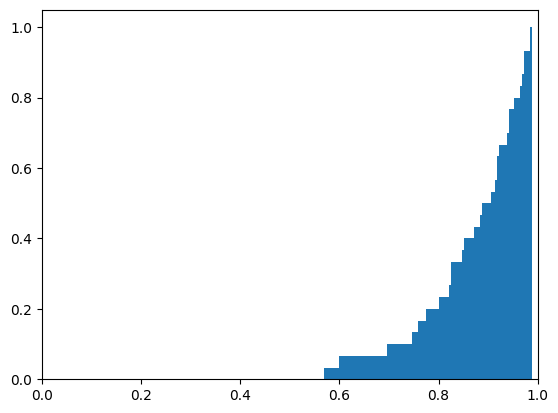

In [18]:

plot_scores_CDF(mo_aucs_hybrid)

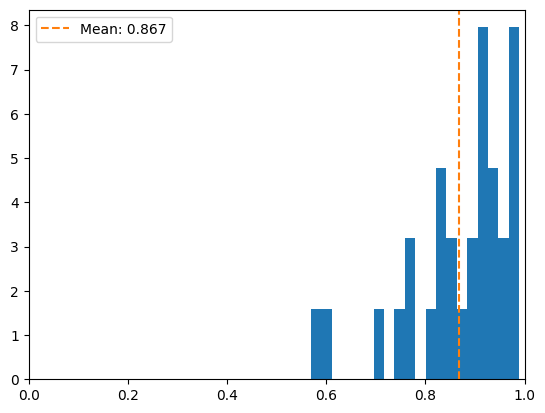

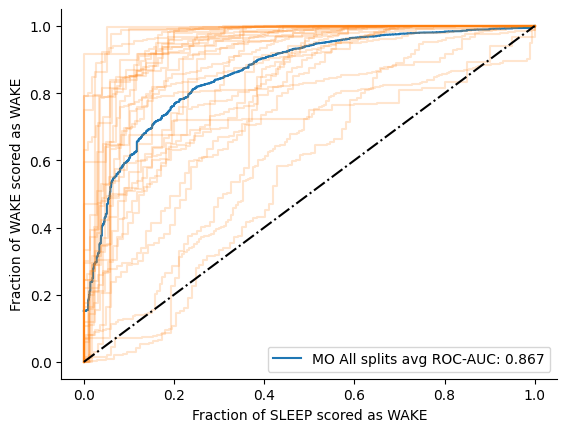

In [19]:

# y so terrible??
# probably timestamp/gap issues
# look at worst ones
plot_scores_PDF(mo_aucs_hybrid)

add_rocs(mo_fprs_hybrid, mo_tprs_hybrid, roc_group_name="MO")

In [20]:

log_reg_preprocessed_data_hybrid = [
    (d, DATA_SET.ids[i])
    for i in range(len(split_models))
    if (d := split_models[i].get_needed_X_y(DATA_SET, DATA_SET.ids[i])) is not None
]

log_reg_evaluations_hybrid: Dict[str, dict] = {}
for i, ((X, y), id) in enumerate(log_reg_preprocessed_data_hybrid):
    y_hat_proba = split_models[i].predict_probabilities(X)
    y_hat_sleep_proba = y_hat_proba[:, 1].reshape(-1,)
    y_prepped, _ = SGDLogisticRegression()._prepare_labels(y)
    try:
        analysis = split_analysis(y_prepped, y_hat_sleep_proba, balancing=False)
    except ValueError as e:
        print(f"Error processing {id}: {e}")
        continue
    # analysis = split_analysis(y, y_hat_proba)
    log_reg_evaluations_hybrid[id] = analysis
    print(f"Processing {i+1} of {len(log_reg_preprocessed_data_hybrid)} ({id})... AUROC: {analysis['auc']}")
log_reg_aucs_hybrid = [e["auc"] for e in log_reg_evaluations_hybrid.values()]
log_reg_fprs_hybrid = [e["roc_curve"]["fprs"] for e in log_reg_evaluations_hybrid.values()]
log_reg_tprs_hybrid = [e["roc_curve"]["tprs"] for e in log_reg_evaluations_hybrid.values()]


masking
Masked 1 PSG epochs
masking
Masked 2 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
ID 7749105 not found in walch_et_al
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
masking
Masked 1 PSG epochs
Processing 1 of 29 (1066528)... AUROC: 0.7313786905101711
Error processing 1360686: Found input variables with inconsistent numbers of samples: [956, 91

/Users/eric/Engineering/Work/pisces/pisces/utils.py:424: UserWarning: y_hat is shorter than y by -42 elements, returning y unchanged
  warnings.warn(f"y_hat is shorter than y by {pad} elements, returning y unchanged")


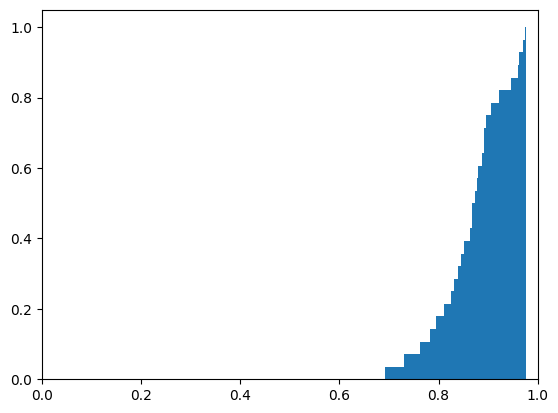

In [21]:


plot_scores_CDF(log_reg_aucs_hybrid)

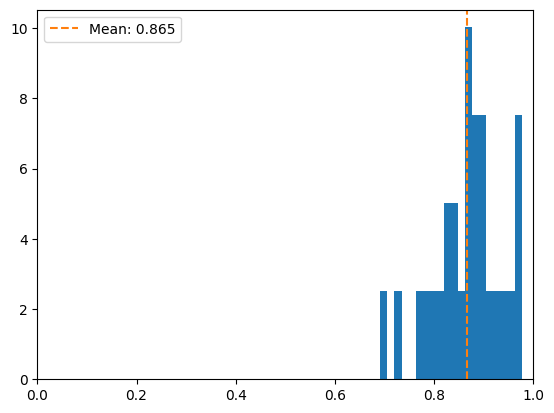

In [22]:
plot_scores_PDF(log_reg_aucs_hybrid)

### Comparision ROC

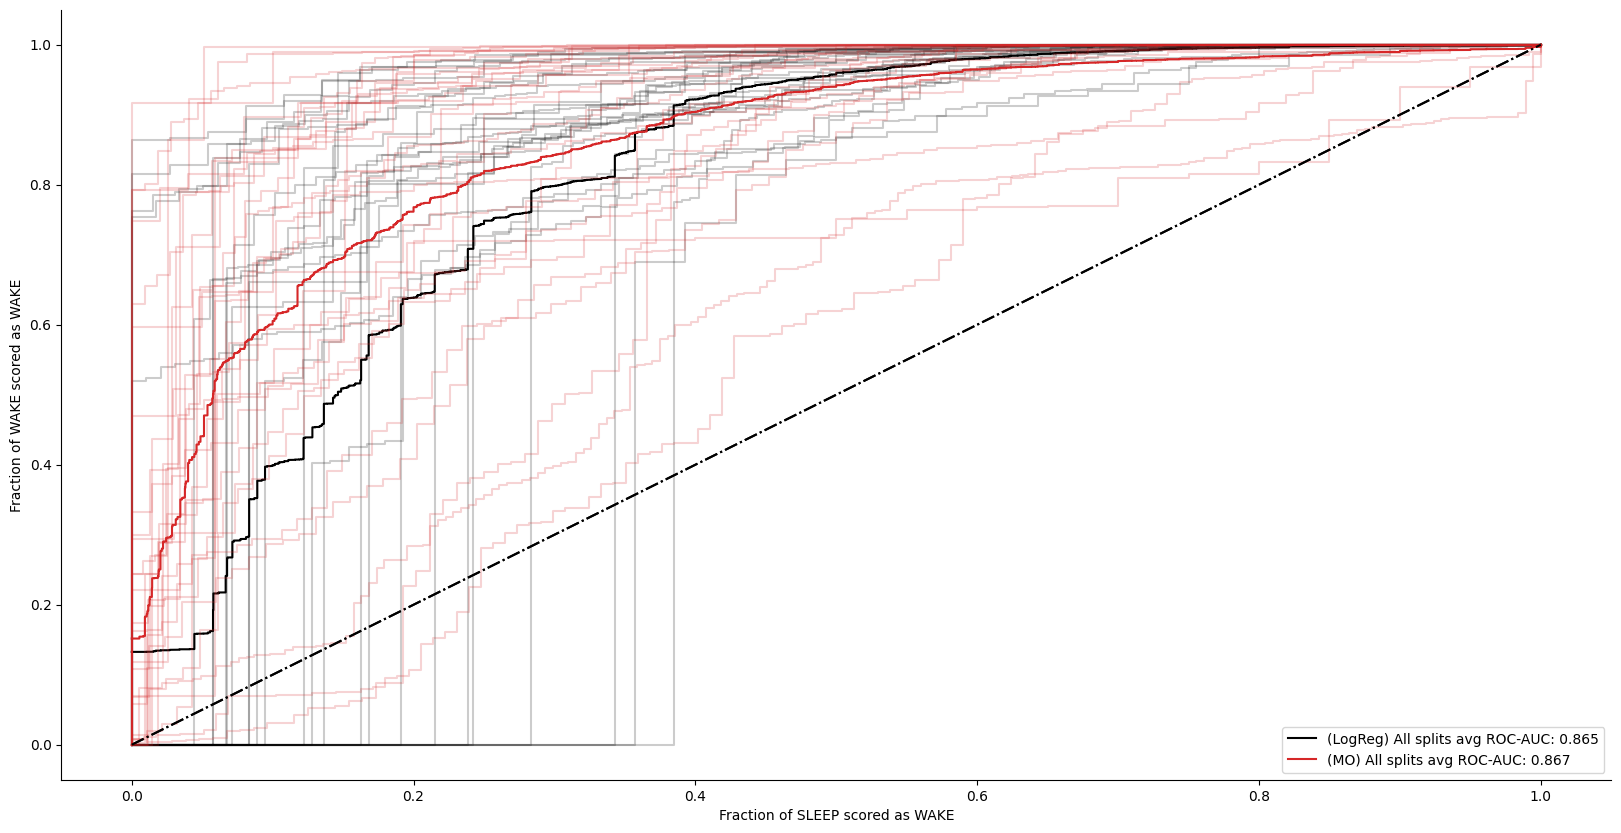

In [23]:


fig, ax = plt.subplots(figsize=(20, 10))
add_rocs(
    fprs=log_reg_fprs_hybrid,
    tprs=log_reg_tprs_hybrid,
    # min_auc=0.7, 
    avg_curve_color=lr_color,
    specific_curve_color=lr_color,
    roc_group_name="(LogReg)",
    ax=ax,
)

add_rocs(
    fprs=mo_fprs_hybrid,
    tprs=mo_tprs_hybrid,
    avg_curve_color=mo_color,
    specific_curve_color=mo_color,
    # min_auc=0.7,
    roc_group_name="(MO)",
    ax=ax
)
ax.legend(loc='lower right')

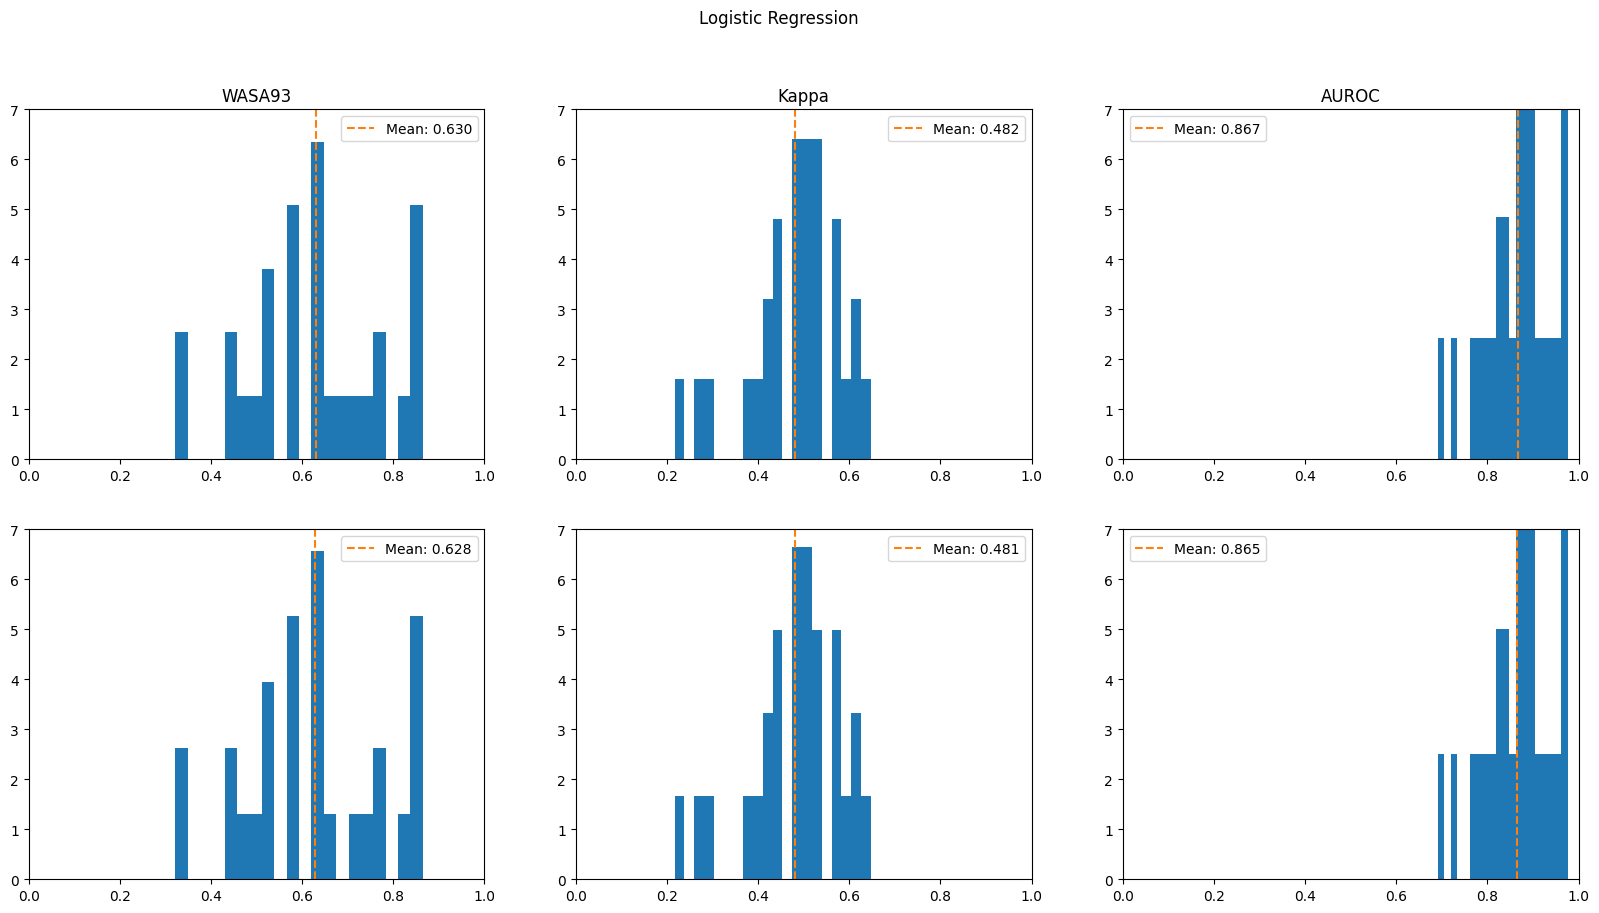

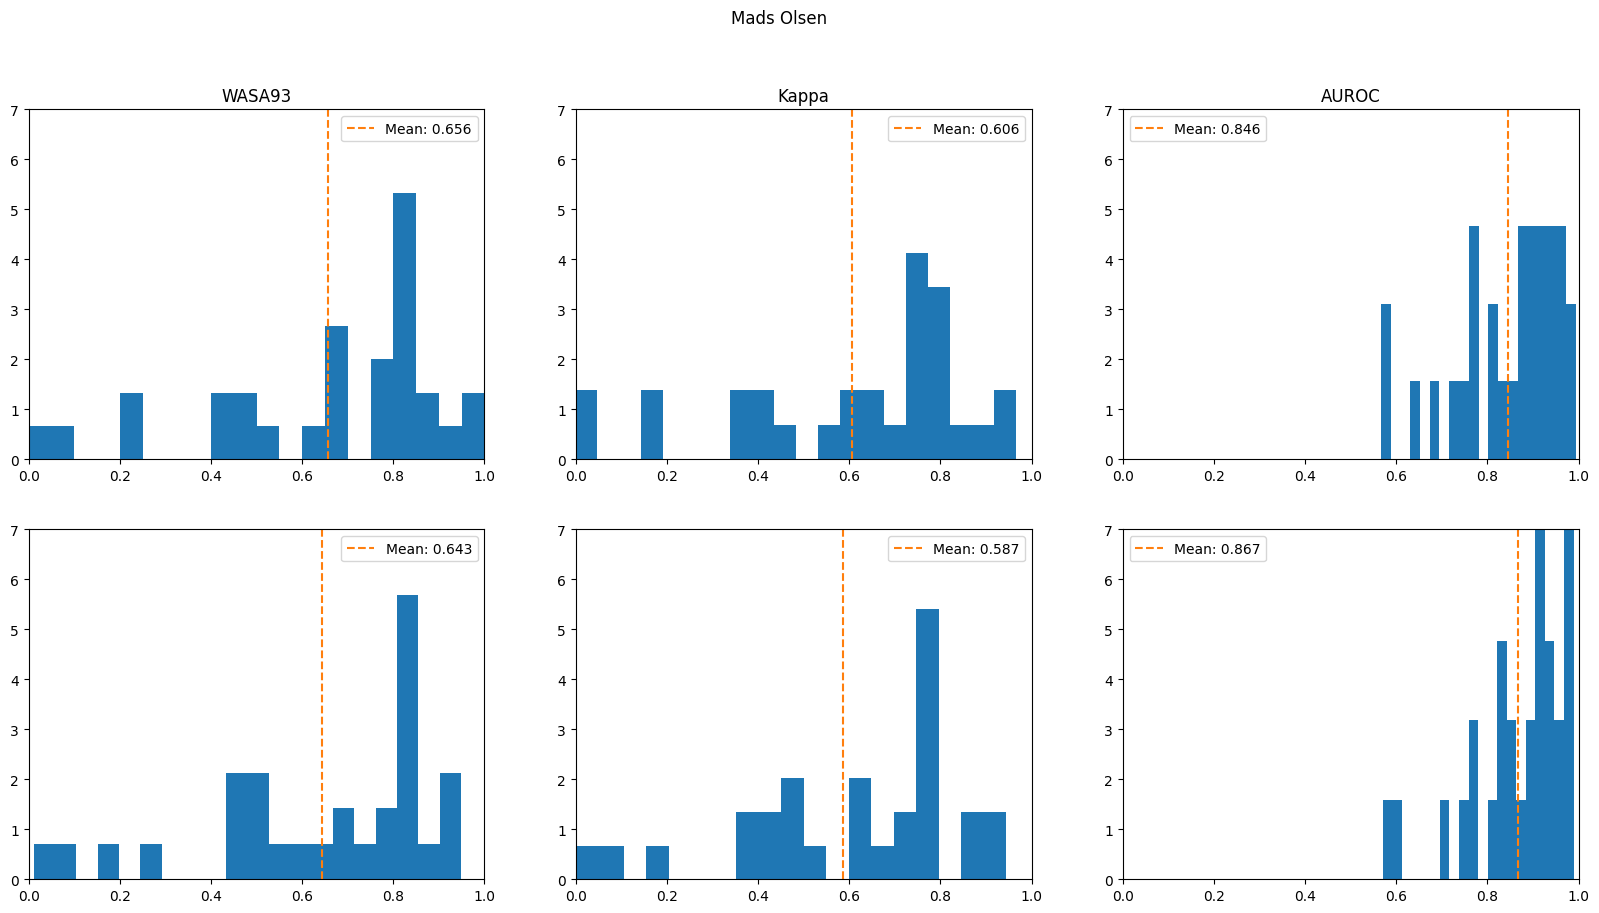

In [24]:
log_reg_wasa_93_hybrid = [e[f"wasa93"] for e in log_reg_evaluations_hybrid.values()]
mo_wasa_93_hybrid = [e[f"wasa93"] for e in evaluations_hybrid.values()]
log_reg_kappa_hybrid = [e["kappa"] for e in log_reg_evaluations_hybrid.values()]
mo_kappa_hybrid = [e["kappa"] for e in evaluations_hybrid.values()]


log_reg_wasa_93_walch = [e[f"wasa93"] for e in log_reg_evaluations_walch.values()]
mo_wasa_93_walch = [e[f"wasa93"] for e in evaluations_walch.values()]
log_reg_kappa_walch = [e["kappa"] for e in log_reg_evaluations_walch.values()]
mo_kappa_walch = [e["kappa"] for e in evaluations_walch.values()]

plot_titles = [
    f"WASA{int(WASA_THRESHOLD*100)}",
    "Kappa",
    "AUROC",
]
hybrid_data_to_plot = [
    (log_reg_wasa_93_hybrid, mo_wasa_93_hybrid),
    (log_reg_kappa_hybrid, mo_kappa_hybrid),
    (log_reg_aucs_hybrid, mo_aucs_hybrid),
]

walch_data_to_plot = [
    (log_reg_wasa_93_walch, mo_wasa_93_walch),
    (log_reg_kappa_walch, mo_kappa_walch),
    (log_reg_aucs_walch, mo_aucs_walch),
]

ncol = 3
fig_lr, ax_lr = plt.subplots(nrows=2, ncols=ncol, figsize=(20, 10))
fig_mo, ax_mo = plt.subplots(nrows=2, ncols=ncol, figsize=(20, 10))

fig_lr.suptitle("Logistic Regression")
fig_mo.suptitle("Mads Olsen")


for i, pair in enumerate(walch_data_to_plot):
    lr, mo = pair
    plot_scores_PDF(lr, ax=ax_lr[0, i])
    plot_scores_PDF(mo, ax=ax_mo[0, i])

    ax_lr[0, i].set_title(plot_titles[i])
    ax_mo[0, i].set_title(plot_titles[i])
    ax_lr[0, i].legend()
    ax_mo[0, i].legend()

for i, pair in enumerate(hybrid_data_to_plot):
    lr, mo = pair
    plot_scores_PDF(lr, ax=ax_lr[1, i])
    plot_scores_PDF(mo, ax=ax_mo[1, i])

    ax_lr[1, i].legend()
    ax_mo[1, i].legend()

for ax_set in [ax_lr, ax_mo]:
    for i in range(ncol):
        for j in range(2):
            ax_set[j, i].set_ylim(0, 7)


In [25]:
acc_mean_gaps = []
acc_median_gaps = []
excludes = []
for id in walch.ids:
    psg = walch.get_feature_data("psg", id)
    acc = walch.get_feature_data("accelerometer", id)
    if psg is None or acc is None:
        excludes.append(id)
        continue

    psg_time = psg[:, 0].to_numpy()
    acc_time = acc[:, 0].to_numpy()
    acc_mean_gap = np.mean(np.diff(acc_time))
    acc_median_gap = np.median(np.diff(acc_time))

    acc_mean_gaps.append(acc_mean_gap)
    acc_median_gaps.append(acc_median_gap)
    # print(f"ID: {id}, mean gap: {acc_mean_gap}, median gap: {acc_median_gap}")
    if acc_mean_gap > 0.04:
        print(f"!!!!!ID: {id}, mean gap: {acc_mean_gap}, median gap: {acc_median_gap}")
        excludes.append(id)

!!!!!ID: 5383425, mean gap: 0.09995511555394894, median gap: 0.09990299999844865
ID 7749105 not found in walch_et_al
!!!!!ID: 8258170, mean gap: 0.09989854006413004, median gap: 0.09988399999929243
